# Fun with neural nets

In [2]:
%matplotlib inline

import pdb
import numpy as np
import tensorflow as tf
from scipy.io import loadmat
import matplotlib.pyplot as plt
from scipy.optimize import fmin_cg

import warnings
warnings.filterwarnings('ignore')

## Neural net cost function with regularization

In [3]:
def nn_cost_function(nn_params, input_layer_size, hidden_layer_size,
                     num_labels, X, y, lam):
    # nn_cost_function Implements the neural network cost function for a two layer
    # neural network which performs classification
    #   J = nn_cost_function(nn_params, hidden_layer_size, num_labels,
    #   X, y, lambda) computes the cost and gradient of the neural network. The
    #   parameters for the neural network are "unrolled" into the vector
    #   nn_params and need to be converted back into the weight matrices.
    #
    #   The returned parameter grad should be a "unrolled" vector of the
    #   partial derivatives of the neural network.

    # Reshape nn_params back into the parameters theta1 and theta2
    # for our 2 hidden-layer neural network
    mid = hidden_layer_size * input_layer_size
    theta1 = np.reshape(nn_params[:mid], (hidden_layer_size, input_layer_size)) #25x401
    theta2 = np.reshape(nn_params[mid:], (num_labels, hidden_layer_size + 1)) #10x26
    
    J = 0
    num_samples = X.shape[0]
    theta1_grad = np.zeros(theta1.shape)
    theta2_grad = np.zeros(theta2.shape)

    # add bias to the input data
    bias = np.ones((num_samples, 1))
    X1 = np.concatenate((bias, X), axis=1)
    
    # forward propagate
    layer1 = sigmoid(theta1.dot(X1.T))
    bias = np.ones((1, layer1.shape[1]))
    layer2 = np.concatenate((bias, layer1), axis=0)
    output = sigmoid(theta2.dot(layer2))

    # reshape y to nn format, one hot encoding
    ynn = np.zeros((num_samples, num_labels))
    for i in range(num_samples):
        ynn[i, y[i] -1] = 1 # column 10 represents digit 0
    #end
    ynn = ynn.T
    
    # cost function - first without regularization
    J = (-1 / num_samples) * np.sum(np.sum( ynn * np.log(output) + (1 - ynn) * np.log(1 - output) ))
    
    # cost function - first with regularization
    sum_layer1 = np.sum(np.sum( theta1[:, 1:-1] **2 ))
    sum_layer2 = np.sum(np.sum( theta2[:, 1:-1] **2 ))
    reg = (lam / (2 * num_samples)) * (sum_layer1 + sum_layer2)
    J = J + reg

    return J
#end


## Neural net cost function gradient

In [4]:
def nn_cost_function_gradient(nn_params, input_layer_size, hidden_layer_size, 
                              num_labels, X, y, lam):
    # nn_cost_function Implements the neural network cost function for a two layer
    # neural network which performs classification
    #   grad = nn_cost_function(nn_params, hidden_layer_size, num_labels,
    #   X, y, lambda) computes the cost and gradient of the neural network. The
    #   parameters for the neural network are "unrolled" into the vector
    #   nn_params and need to be converted back into the weight matrices.
    #
    #   The returned parameter grad should be a "unrolled" vector of the
    #   partial derivatives of the neural network.

    # Reshape nn_params back into the parameters theta1 and theta2
    # for our 2 hidden-layer neural network
    
    mid = hidden_layer_size * input_layer_size
    theta1 = np.reshape(nn_params[:mid], (hidden_layer_size, input_layer_size)) #25x401
    theta2 = np.reshape(nn_params[mid:], (num_labels, hidden_layer_size + 1)) #10x26
    
    num_samples = X.shape[0]
    theta1_grad = np.zeros(theta1.shape)
    theta2_grad = np.zeros(theta2.shape)

    # add bias to the input data
    bias = np.ones((num_samples, 1))
    X1 = np.concatenate((bias, X), axis=1)
    
    # reshape y to nn format, one hot encoding
    ynn = np.zeros((num_samples, num_labels))
    for i in range(num_samples):
        ynn[i, y[i] -1] = 1 # column 10 represents digit 0
    #end
    ynn = ynn.T
    
    # backpropogation, calculation of gradients
    for t in range(num_samples):
        # step 1: forward propagate
        a1 = X1[t, :]
        z2 = theta1.dot(a1.T)
        a2 = sigmoid(z2)
        z2 = np.insert(z2, 0, 1) # need to account for the bias
        a2 = np.insert(a2, 0, 1) # need to account for the bias
        z3 = theta2.dot(a2.T)
        a3 = sigmoid(z3)
        
        # step 2: compute error
        delta3 = a3 - ynn[:, t]

        # step 3: back propagate error through activation function
        delta2 = (theta2.T.dot(delta3)) * (a2 * (1 - a2))
        # step 4: update weights
        theta2_grad = theta2_grad + np.outer(delta3, a2)
        theta1_grad = theta1_grad + np.outer(delta2[1:], a1)
    # end

    # step 5: average gradient update
    theta1_grad = theta1_grad / num_samples
    theta2_grad = theta2_grad / num_samples
    
    # regularization
    theta1_tmp = np.copy(theta1)
    theta1_tmp[:, 0] = 0 # don't regularize bias terms
    theta1_grad = theta1_grad + lam * theta1_tmp / num_samples
    theta2_tmp = np.copy(theta2)
    theta2_tmp[:, 0] = 0
    theta2_grad = theta2_grad + lam * theta2_tmp / num_samples

    # unroll gradients
    theta1_flat = theta1_grad.flatten()
    theta2_flat = theta2_grad.flatten()
    grad = np.concatenate((theta1_flat, theta2_flat))
    
    return grad
# end


## Sigmoid function

In [5]:
def sigmoid(z):
    # sigmoid Compute sigmoid functoon
    # g = sigmoid(z) computes the sigmoid of z
    g = 1 / (1 + np.exp(-z))
    
    return g
# end


## Classifying MNIST digits from pre-learned weights

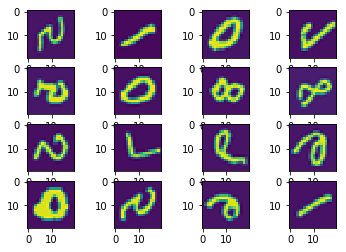

Loading saved neural network parameters ...

Training neural network... 

Cost without regularization: 0.2876 

Cost with regularization: 0.3811 



In [9]:
# 5000 Mnist digits
data = loadmat('ex4data1.mat')
X = data['X']
y = data['y']

# 5000 samples, 500 from each class
n = X.shape[0]

# num of pixels per sample
d = X.shape[1]

# digits from 0 through 9
c = np.unique(y).size

# randomly select 16 image to display
fig = plt.figure()
for i in range(1, 17):
    index = np.random.randint(low=0, high=4999, size=1)
    image = np.reshape(X[index, :], (20, 20))
    fig.add_subplot(4, 4, i)
    plt.imshow(image)
# end
plt.show()

# load pre-learned weights
print('Loading saved neural network parameters ...\n')
weights = loadmat('ex4weights.mat')
theta1 = weights['Theta1']
theta2 = weights['Theta2']
weights_flat = np.concatenate((theta1.flatten(), theta2.flatten()))

# cost without regularization
print('Training neural network... \n')
lam = 0
J = nn_cost_function(weights_flat, theta1.shape[1], theta1.shape[0], c, X, y, lam)
print('Cost without regularization: %2.4f \n' % J)

# cost with regularization
lam = 1
J = nn_cost_function(weights_flat, theta1.shape[1], theta1.shape[0], c, X, y, lam)
print('Cost with regularization: %2.4f \n' % J)


## Classifying MNIST digits from random weights

In [13]:
def print_progress(theta):
    # callback function for fmin_cg to print out process
    global Nfeval
    print('{0:4d}   {1: 2.4f}'.format(Nfeval, nn_cost_function(theta, d+1, t, c, X, y, lam)))
    Nfeval += 1
# end

Nfeval = 1

# initializing random weights
print('initializing neural network narameters ...\n')
t = theta1.shape[0]
layer1_size = t * (d + 1) # 25x401
layer2_size = c * (t + 1) # 10x26
init_theta = np.random.rand(layer1_size + layer2_size, 1)

# group the arguments
args = (d+1, t, c, X, y, lam)

# start minimizing cost
print('Training neural network... \n')
print('{0:4s}   {1:9s}'.format('Iter', ' cost'))
theta_opt = fmin_cg(nn_cost_function, init_theta, nn_cost_function_gradient,
                    args=args, maxiter=50, callback=print_progress, disp=0)

# reshape the weights to correct sizes
theta1_opt = np.reshape(theta_opt[:layer1_size], (t, d + 1)) # 25x401
theta2_opt = np.reshape(theta_opt[layer1_size:], (c, t + 1)) # 10x26



initializing neural network narameters ...

Training neural network... 

Iter    cost    
   1    7.8461
   2    4.2100
   3    4.1856
   4    3.6857
   5    3.5969
   6    3.5868
   7    3.5866
   8    3.5773
   9    3.3094
  10    3.3009
  11    3.3006
  12    3.2911
  13    3.2709
  14    3.2594
  15    3.2588
  16    3.2556
  17    3.1085
  18    3.1054
  19    3.0303
  20    2.9972
  21    2.9434
  22    2.8884
  23    2.8378
  24    2.7640
  25    2.6256
  26    2.4944
  27    2.3478
  28    2.2475
  29    2.1004
  30    1.8613
  31    1.7592
  32    1.6824
  33    1.6270
  34    1.5987
  35    1.5653
  36    1.5146
  37    1.3460
  38    1.2637
  39    1.1873
  40    1.1508
  41    1.1176
  42    1.1009
  43    1.0627
  44    0.9861
  45    0.9348
  46    0.9069
  47    0.8659
  48    0.8296
  49    0.7907
  50    0.7612
